<a href="https://colab.research.google.com/github/odhrandooley/Met-Eireann/blob/main/ESA_CORINE_ECOSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialisation

##Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install netcdf4
!pip install rasterio
!pip install pyproj
!pip install rioxarray

import xarray as xr
import rioxarray as rio

import matplotlib.pyplot as plt
import os
import numpy as np


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, ColorConverter
from osgeo import gdal
from pyproj import Proj, transform
!pip install git+git://github.com/geopandas/geopandas.git

import pandas as pd
import geopandas as gpd


import matplotlib.image as img
import tifffile as tif
import xml.etree.ElementTree as ET


import rasterio
import cv2
from rasterio import plot
from rasterio.plot import show
from skimage import exposure

File names

In [ ]:
fnESACCI='/content/drive/MyDrive/ESA-CCI/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc'
file_legend='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/Legend/CLC2018_CLC2018_V2018_20_QGIS.txt'
fncorine='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'
fnameSG='/content/drive/MyDrive/ECOCLIMAP_SG/ecosg_final_map.dir' #ecosg filename
covernamef='/content/drive/MyDrive/ECOCLIMAP_SG/ECOCLIMAP_SG_cover_data.csv' #file with all the cover name


Cover + colourmaps

In [ ]:
PrimeCover = ['Water','Nature','Urban','Difference']

In [ ]:
c1=(0/255.0,0/255.0,128/255.0,255/255.0)##navy blue 1. Water
c2=(50/255.0,205/255.0,50/255.0,255/255.0)##limegreen 3. nature
c3=(138/255.0,2/255.0,0/255.0,255/255.0)## red 4 urban
c0=(0/255.0,0/255.0,0/255.0,255/255.0)## 0 no value
scheme=[c0,c1,c2,c3]
colCOR = ListedColormap(scheme)

##Initial cutting

In [ ]:
#Coordinates for CORINE,ECOSG,ESACCI initial cutting around Ireland


LATMAX=58
LATMIN=49
LONMIN=-12
LONMAX=-3

latmax=58
latmin=49
lonmin=-12
lonmax=-3

projection = 'EPSG:3035'
PROJECTION=Proj(projection)

projx,projy=PROJECTION(longitude=[lonmin,lonmax,lonmax,lonmin],
                       latitude=[latmin,latmax,latmin,latmax])
xmin=min(projx)
xmax=max(projx)
ymin=min(projy)
ymax=max(projy)

Cutting CORINE

In [ ]:


src_fn=fncorine
out_fn='CORINEcut100m.tif' # 10m cutted filename
ds=gdal.Open(src_fn)
gdal.Translate(out_fn,ds,projWin = [xmin,ymax,xmax,ymin],projWinSRS=projection) 

!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: CORINEcut100m.tif
Size is 8178, 11169
Coordinate System is:
PROJCS["ETRS89 / LAEA Europe",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",52],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",4321000],
    PARAMETER["false_northing",3210000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","3035"]]
Origin = (2738200.000000000000000,4077100.000000000000000)
Pixel Size = (100.000000000000000,-100.000000000000000)
Metadata:
  AREA_OR_POINT=Area


Cut and reproject ECOSG

In [ ]:


inECO = gdal.Open(fnameSG)
cutECO = 'ECO_cut.tif'

gdal.Translate(cutECO,inECO,
               projWin=[lonmin,latmax,lonmax,latmin], 
               projWinSRS='EPSG:4326')

dsECO=gdal.Open(cutECO)

projection = 'EPSG:3035'
warpSG = 'ECO_3035.tif'
gdal.Warp(warpSG, dsECO, dstSRS=projection,srcSRS='EPSG:4326',xRes=100,yRes=100)

outECO = 'ECOcut3035.tif'
dscutECO = gdal.Open(warpSG)
gdal.Translate(outECO,dscutECO,projWin = [xmin,ymax,xmax,ymin],projWinSRS=projection)

!gdalinfo $outECO

#pixel size and number is the same, just slightly different bounds

ESACCI

In [ ]:


#xds = xr.open_dataset(fnESACCI)
#xds.rio.write_crs("epsg:4326", inplace=True)
ncfile = xr.open_dataset(fnESACCI)
#Crop the file

LAT=ncfile['lat'][(ncfile['lat']<LATMAX)&(ncfile['lat']>LATMIN)]
LON=ncfile['lon'][(ncfile['lon']<LONMAX)&(ncfile['lon']>LONMIN)]
var=ncfile['lccs_class'][0,(ncfile['lat']<LATMAX)&(ncfile['lat']>LATMIN),
                         (ncfile['lon']<LONMAX)&(ncfile['lon']>LONMIN)]

#Check for the CRS
print(ncfile['crs'])
# add the crs value
var.rio.write_crs("epsg:4326", inplace=True)
#var=var.rio.set_crs("epsg:4326")

inESA  = 'raster.tif'
var.rio.to_raster(inESA)

<xarray.DataArray 'crs' ()>
array(-2147483647, dtype=int32)
Attributes:
    wkt:      GEOGCS["WGS 84", \n  DATUM["World Geodetic System 1984", \n    ...
    i2m:      0.002777777777778,0.0,0.0,-0.002777777777778,-180.0,90.0


In [ ]:
#Cut and project ESACCI

inESA  = 'raster.tif'

cutESA = 'ESA_cut.tif'

gdal.Translate(cutESA,inESA,
               projWin=[lonmin,latmax,lonmax,latmin], 
               projWinSRS='EPSG:4326')

dsESA=gdal.Open(cutESA)
print(dsESA)
projection = 'EPSG:3035'
warpESA = 'ESA_3035.tif'
gdal.Warp(warpESA, dsESA, dstSRS=projection,srcSRS='EPSG:4326',xRes=100,yRes=100)

outESA = 'ESAcut3035.tif'
dscutESA = gdal.Open(warpESA)            
gdal.Translate(outESA,dscutESA,projWin = [xmin,ymax,xmax,ymin],
               projWinSRS=projection)

!gdalinfo $outESA

#pixel size and number is the same, just slightly different bounds

#Open Data

##misc functions

In [ ]:
def cover_fraction(filename):
    data=open(filename)
    covernum=[]
    covername=[]
    cityfrac=[]
    vegfrac=[]
    inwaterfrac=[]
    seafrac=[]
    for i,d in enumerate(data):
        if i==0:
            fieldnames=d.split(',')
            covername.append('no data')
            cityfrac.append(0.0)
            vegfrac.append(0.0)
            inwaterfrac.append(0.0)
            seafrac.append(0.0)
        else:
#           print(d.split(','))
            covernum.append(int(d.split(',')[0]))
            covername.append(d.split(',')[1])
            cityfrac.append(float(d.split(',')[2]))
            vegfrac.append(float(d.split(',')[3]))
            inwaterfrac.append(float(d.split(',')[4]))
            seafrac.append(float(d.split(',')[5]))
    return(fieldnames,np.array(covernum),covername,np.array(cityfrac),np.array(vegfrac),
           np.array(inwaterfrac),np.array(seafrac))

In [ ]:
def read_legend_file(file_legend):

  data=open(file_legend)
  text=[t for t in data]
  covernum=[int(d.split(',')[0]) for d in text]
  colors=[tuple((int(d.split(',')[1])/255.0,int(d.split(',')[2])/255.0,int(d.split(',')[3])/255.0,int(d.split(',')[4])/255.0)) for d in text]
  covername=[d.split(',')[5] for d in text]
  return(data,text,covernum,colors,covername)

##Get lat,lon,array

In [ ]:
def get_data(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[a:b,c:d]

    return (LAT,LON,D)

##Convert to Primary

In [ ]:

#plotcol and numcol correspond to column number of each 
def toPrimaryDF(array, df,plotcol,numcol,covername):
  array1 = np.zeros([len(array),len(array[0])])
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):
      for k in range(0,len(covername)):
        if array[i,j]== df.iloc[k,plotcol]:
          array1[i,j]=df.iloc[k,numcol] #assigns 1,2 or 3 to a new array based on primary covertype
  return array1



CORINE

In [ ]:

primary = []
for i in range(0,11):
  primary.append('Urban')
for i in range(11,39):
  primary.append('Nature')
for i in range(39,45):
  primary.append('Water')
  
primarynum = []
for i in range(0,11):
  primarynum.append('3')
for i in range(11,39):
  primarynum.append('2')
for i in range(39,45):
  primarynum.append('1')

In [ ]:
columns = ['Covername','Covernumber','Primary','Secondary']
index = np.arange(1,46,1)
df_COR = pd.DataFrame(index = index, columns = columns)

(data,text,covernum,colors,covername_COR) = read_legend_file(file_legend)

df_COR['Covername'] = covername_COR
df_COR['Plotnum'] = index
df_COR['Covernumber'] = covernum
df_COR['Primary'] = primary
df_COR['PrimaryNum'] = primarynum

ECOSG

In [ ]:

primarynum = []
for i in range(0,3):
  primarynum.append('1')
for i in range(3,23):
  primarynum.append('2')
for i in range(23,33):
  primarynum.append('3')

primary = []
for i in range(0,3):
  primary.append('Water')
for i in range(3,23):
  primary.append('Nature')
for i in range(23,33):
  primary.append('Urban')

In [ ]:
(fieldnames,covernum,covername_ECO,
 cityfrac,vegfrac,inwaterfrac,seafrac)=cover_fraction(covernamef)

covername_ECO = covername_ECO[1:]

columns = ['Covername','Covernumber','Primary','Secondary']
index = np.arange(1,len(covername_ECO)+1,1)

df_ECO = pd.DataFrame(index = index, columns = columns)
df_ECO['Covername'] = covername_ECO
df_ECO['Plotnum'] = index
df_ECO['Covernumber'] = covernum
df_ECO['Primary'] = primary
df_ECO['PrimaryNum'] = primarynum

ESA

In [ ]:

primarynum = []
primarynum.append('1')
for i in range(1,32):
  primarynum.append('2')
primarynum.append('3')
for i in range(33,36):
  primarynum.append('2')
primarynum.append('1')
primarynum.append('2')

primary = []
primary.append('Water')
for i in range(1,32):
  primary.append('Nature')
primary.append('Urban')
for i in range(33,36):
  primary.append('Nature')
primary.append('Water')
primary.append('Nature')

In [ ]:
covername_ESA = var.flag_meanings.split()
covernum = var.flag_values

columns = ['Covername','Covernumber','Primary','Secondary']
index = np.arange(0,len(covername_ESA),1)

df_ESA = pd.DataFrame(index = index, columns = columns)
df_ESA['Covername'] = covername_ESA
#df_ESA['Plotnum'] = index
df_ESA['Covernumber'] = covernum
df_ESA['Primary'] = primary
df_ESA['PrimaryNum'] = primarynum


##Input Coordinates Here

In [ ]:
#extent is the distance in degrees either side of centre
def get_borders(centre_lat,centre_lon, extent):
  latmin = centre_lat - extent
  latmax = centre_lat + extent
  lonmin = centre_lon - extent
  lonmax = centre_lon + extent
  return latmin,latmax,lonmin,lonmax


In [ ]:
#COORDS

centre_lat = 53.330
centre_lon = -8.223
extent =.02


latmin = centre_lat - extent
latmax = centre_lat + extent
lonmin = centre_lon - extent
lonmax = centre_lon + extent

projection = 'EPSG:3035'
PROJECTION=Proj(projection)

projx,projy=PROJECTION(longitude=[lonmin,lonmax,lonmax,lonmin],
                       latitude=[latmin,latmax,latmin,latmax])
xmin=min(projx)
xmax=max(projx)
ymin=min(projy)
ymax=max(projy)

fname='CORINEcut100m.tif'
LATC,LONC, DCOR = get_data(fname,ymax,ymin,xmax,xmin)
#LATC,LONC, DCOR = get_data(fname,ymax,ymin,xmax,xmin)
fname = outESA
LATESA,LONESA, DESA = get_data(fname,ymax,ymin,xmax,xmin)

fname = outECO
LATECO,LONECO, DECO = get_data(fname,ymax,ymin,xmax,xmin)



In [ ]:
print(np.shape(DCOR))
print(np.shape(DESA))
print(np.shape(DECO))

(51, 38)
(51, 38)
(51, 38)


#Primary and Plotting

In [ ]:
def findDif(array1,array2):
  if np.shape(array1) != np.shape(array2):
    return 'Error: incorrect dimensions'
  else:
    dif = array1 - array2

  for i in range(0,len(dif)):
    for j in range(0,len(dif[0])):
      if dif[i,j] == 0:
        dif[i,j] = array1[i,j]
      else:
        dif[i,j] = 0
  
  return dif


In [ ]:
Covertype = PrimeCover[0:3]

In [ ]:
#DFCOR = toPrimaryDF(DCOR,df_COR,4,5,covername_COR)

In [ ]:
DFCOR = toPrimaryDF(DCOR,df_COR,4,5,covername_COR)
DFECO=toPrimaryDF(DECO,df_ECO,4,5,covername_ECO)
DFESA = toPrimaryDF(DESA,df_ESA,1,4, covername_ESA)

In [ ]:
PROJECTION(3015000,3546000,inverse=True)

(-9.919045895990559, 53.39187026171829)

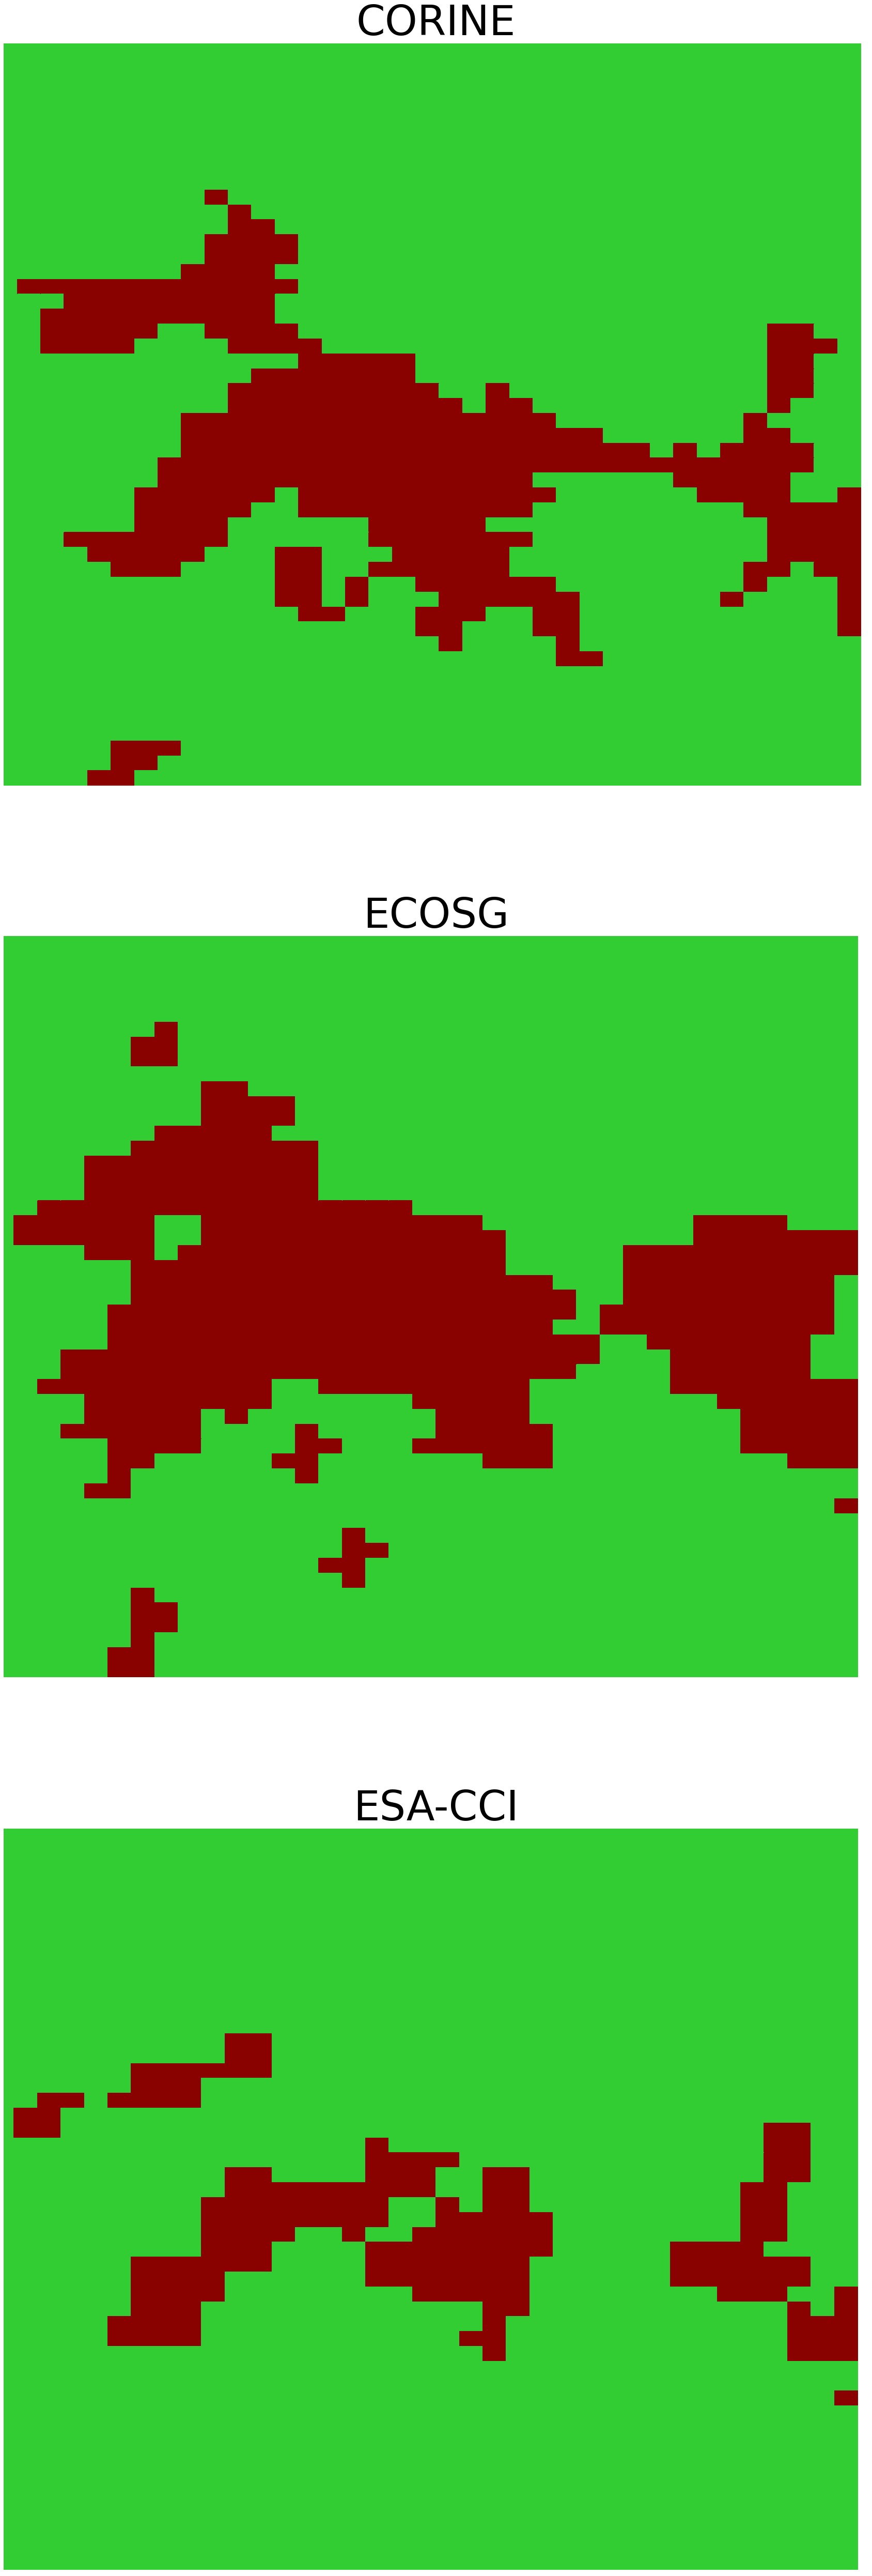

In [ ]:
fig = plt.figure(figsize=(30,90))
gs = fig.add_gridspec(3, 1)
ax0 = fig.add_subplot(gs[0,0])
#ax0.set_title('gs[0, :]')
ax1 = fig.add_subplot(gs[1,0])
#f3_ax2.set_title('gs[1, :-1]')
ax2 = fig.add_subplot(gs[2,0])
#f3_ax3.set_title('gs[1:, -1]')


#fig, axs = plt.subplots(1, 1,figsize=(30, 30))
#ax1=axs

LONg, LATg = np.meshgrid(LONC, LATC)
c=ax0.pcolormesh(LONC,LATC,DFCOR,cmap=colCOR,vmin=0,vmax=len(Covertype))

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)


LONg, LATg = np.meshgrid(LONECO, LATECO)
c=ax1.pcolormesh(LONECO,LATECO,DFECO,cmap=colCOR,vmin=0,vmax=len(Covertype))

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)


LONg, LATg = np.meshgrid(LONESA, LATESA)
c=ax2.pcolormesh(LONESA,LATESA,DFESA,cmap=colCOR,vmin=0,vmax=len(Covertype))

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax0.set_title('CORINE', fontsize= 80)
ax1.set_title('ECOSG', fontsize= 80)
ax2.set_title('ESA-CCI', fontsize= 80)


#cbar_ax = fig.add_subplot(grid[:, 1])
#cb=plt.colorbar(c, ax=cbar_ax, ticks=np.arange(0.5,len(PrimeCover[0:3])),
#                extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(PrimeCover[0:3])
#cb.ax.tick_params(labelsize=15)
#cbar_ax.tick_params(labelsize=15)
#cbar_ax.axis('off')
fig.savefig('InisOirr3plot.png',format='png',quality=95,bbox_inches='tight')

#Barplot and Analysis

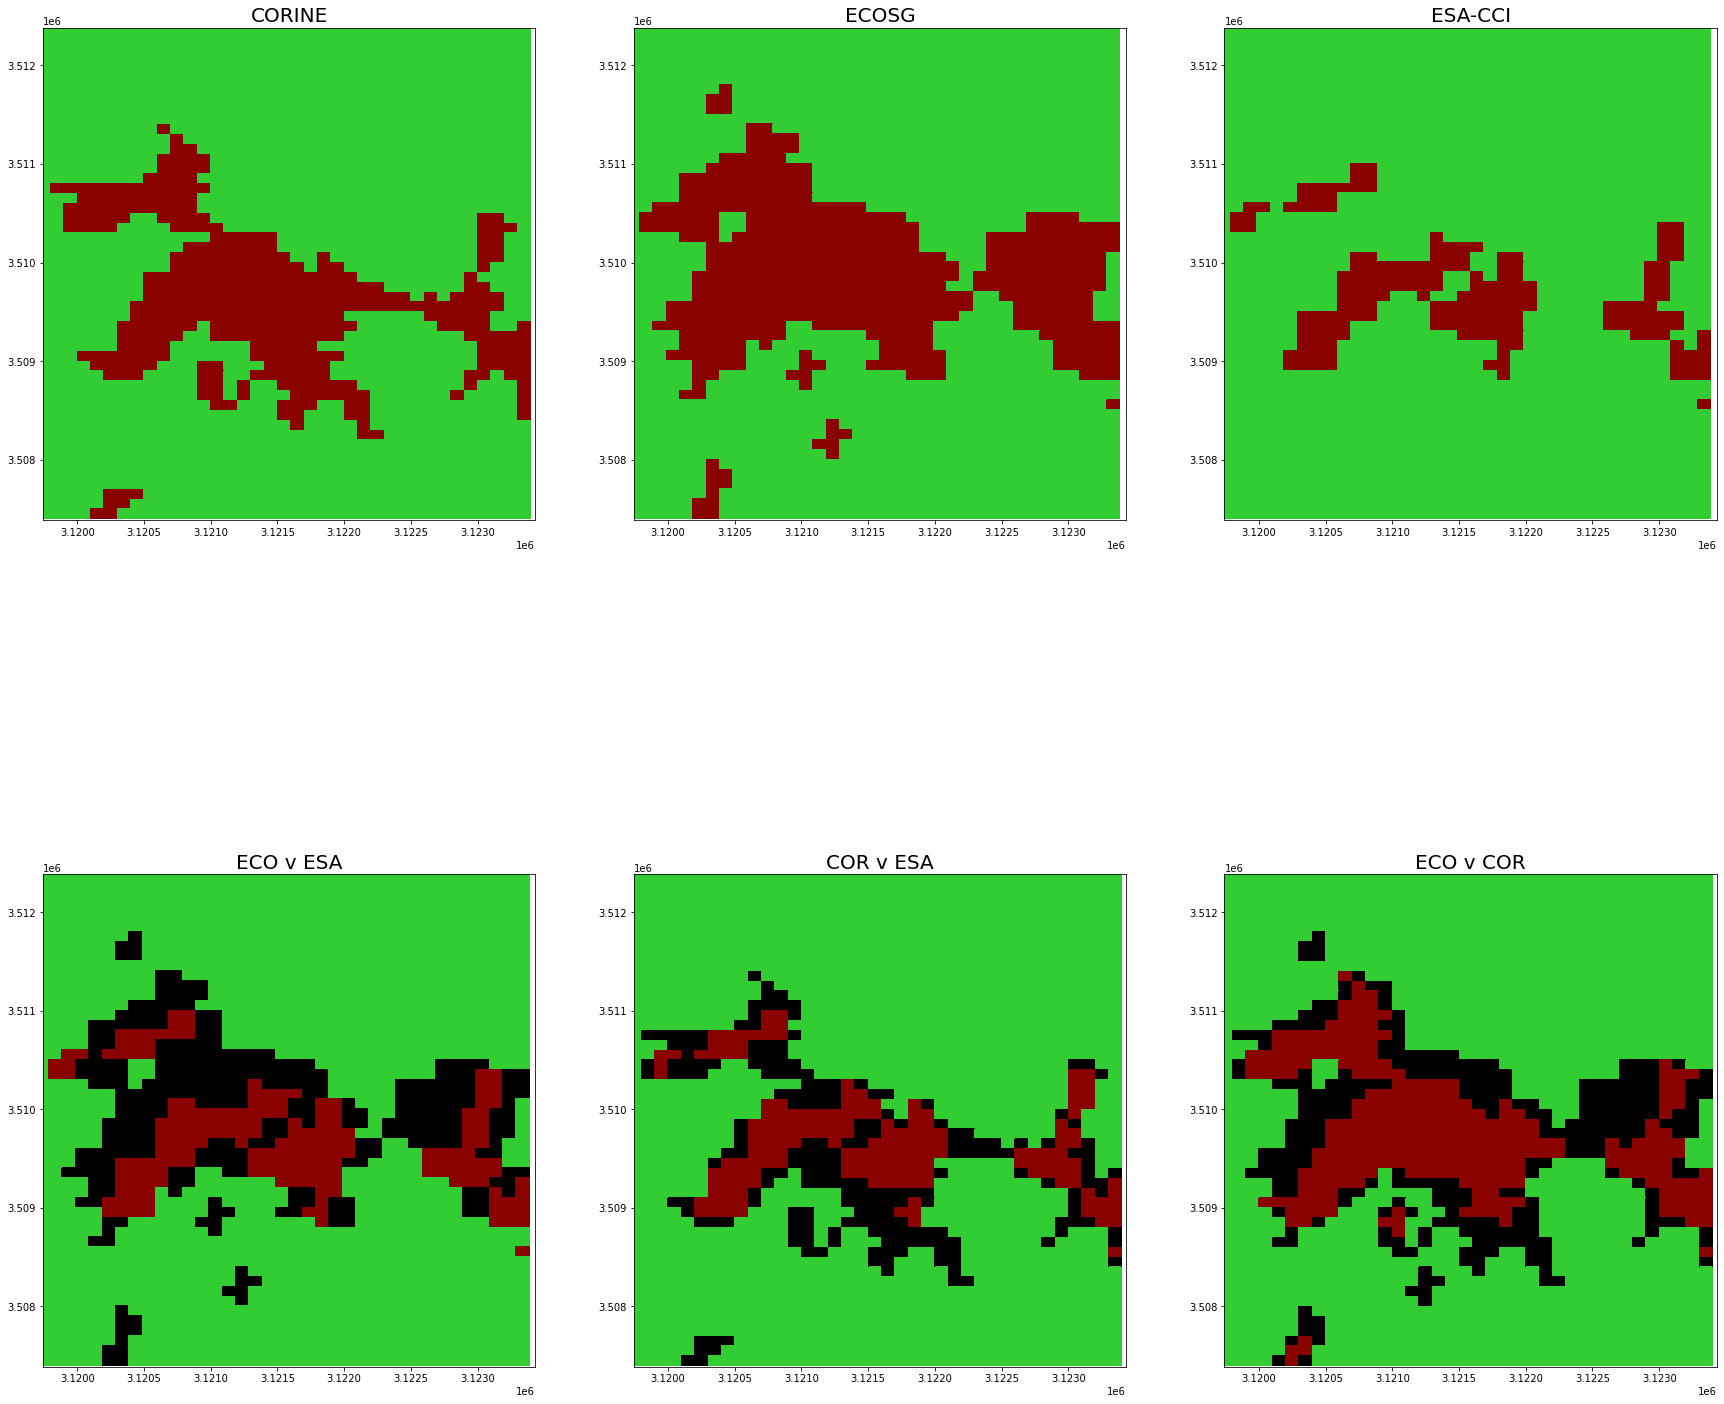

In [ ]:
DifECOESA = findDif(DFESA,DFECO)
DifCORESA = findDif(DFCOR,DFESA)
DifECOCOR = findDif(DFCOR,DFECO)

fig=plt.figure(figsize=(30,30))
grid = plt.GridSpec(2, 3, hspace=0.08, wspace=0.2)

#fig, axs = plt.subplots(1, 1,figsize=(30, 30))
#ax1=axs

ax0=fig.add_subplot(grid[0, 0],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax0.pcolormesh(LONC,LATC,DFCOR,cmap=colCOR,vmin=0,vmax=len(Covertype))

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)


ax1=fig.add_subplot(grid[0, 1],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONECO, LATECO)
c=ax1.pcolormesh(LONECO,LATECO,DFECO,cmap=colCOR,vmin=0,vmax=len(Covertype))

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

ax2=fig.add_subplot(grid[0, 2],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONESA, LATESA)
c=ax2.pcolormesh(LONESA,LATESA,DFESA,cmap=colCOR,vmin=0,vmax=len(Covertype))

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

#ax6=fig.add_subplot(grid[1, 1 ],adjustable='box',
 #                   aspect=(xmin-xmax)/((ymin-ymax)))

#ax6.imshow(DS.transpose(1,2,0))

ax3=fig.add_subplot(grid[1,0 ],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax3.pcolormesh(LONECO,LATECO,DifECOESA,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax5=fig.add_subplot(grid[1,2 ],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax5.pcolormesh(LONC,LATC,DifECOCOR,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax4=fig.add_subplot(grid[1, 1 ],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax4.pcolormesh(LONC,LATC,DifCORESA,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)

ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)

ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin,ymax)





ax0.set_title('CORINE', fontsize= 20)
ax1.set_title('ECOSG', fontsize= 20)
ax2.set_title('ESA-CCI', fontsize= 20)
ax3.set_title('ECO v ESA', fontsize= 20)
ax5.set_title('ECO v COR', fontsize= 20)
ax4.set_title('COR v ESA', fontsize= 20)

#cbar_ax = fig.add_subplot(grid[:, 1])
#cb=plt.colorbar(c, ax=cbar_ax, ticks=np.arange(0.5,len(PrimeCover[0:3])),
#                extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(PrimeCover[0:3])
#cb.ax.tick_params(labelsize=15)
#cbar_ax.tick_params(labelsize=15)
#cbar_ax.axis('off')
fig.savefig('Roundstone.png',format='png',quality=95,bbox_inches='tight')

In [ ]:
def Bar(array):
  
  water =  0
  nature = 0
  urban = 0 
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):

      if array[i,j] == 1:
        water +=1
      if array[i,j] ==2:
        nature +=1  
      if array[i,j] ==3:
        urban +=1
  a = np.array([water,nature,urban])/np.size(array)*100
  return a


In [ ]:
BarCORINE = Bar(DFCOR)
BarECO = Bar(DFECO)
BarESA = Bar(DFESA)


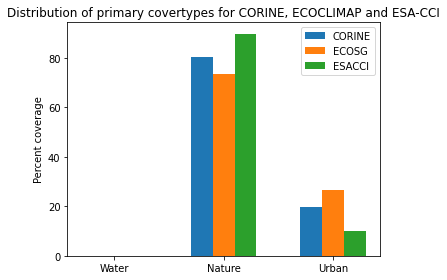

In [ ]:


labels = Covertype
fig, ax = plt.subplots()
ax.set_ylabel('Percent coverage')
ax.set_title('Distribution of primary covertypes for _____')



data = [BarCORINE,BarECO,BarESA]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars



rects1 = ax.bar(x - width, data[0], width, label='CORINE')
rects2 = ax.bar(x         , data[1], width, label='ECOSG')
rects2 = ax.bar(x + width, data[2], width, label='ESA-CCI')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent coverage')
ax.set_title('Distribution of primary covertypes for CORINE, ECOCLIMAP and ESA-CCI')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(labels=['CORINE', 'ECOSG','ESACCI'])

fig.tight_layout()

plt.show()
fig.savefig('Bar1.png',format='png',quality=95,bbox_inches='tight')

In [ ]:
#comboplot
def diffBar(array1,array2,labels):
  if np.shape(array1) != np.shape(array2):
    return print('Error, dimensions of arrays are inconsistent')
  b = len(labels)
  a = np.zeros([b,b])
  for i in range(0, len(array1)):
    for j in range(0,len(array1[0])):
      for k in range(0,b):
        for f in range(0,b):
          if array1[i,j] == k+1:
            if array2[i,j]==f+1:
              a[k,f] += 1
  return a/np.size(array1)*100

In [ ]:
Dif_ECOCOR=diffBar(DFECO,DFCOR, Covertype)
Dif_ECOCOR

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , 69.45304438,  4.12796698],
       [ 0.        , 10.78431373, 15.63467492]])

In [ ]:
bar12

[0.0, 69.45304437564499, 4.12796697626419]

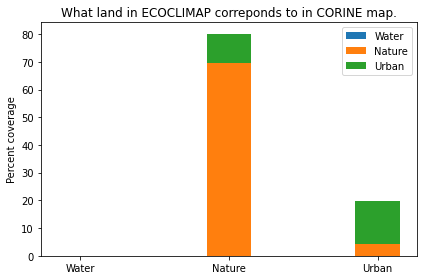

In [ ]:
#barplot where bars show what covertypes a covertype in one map is made up of 

labels = Covertype
fig, ax = plt.subplots()

data =Dif_ECOCOR
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

bar12 = np.add(data[0,:], data[1,:]).tolist()
bar123 = np.add(bar12, data[2,:]).tolist()
#bar1234 = np.add(bar123, data[3,:]).tolist()



ax.bar(x , data[0,:], width, label=labels[0])
ax.bar(x , data[1,:], width, bottom=data[0,:], label=labels[1])
ax.bar(x , data[2,:], width, bottom=bar12, label=labels[2])
#ax.bar(x , data[3,:], width, bottom=bar123,label=labels[3])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent coverage')
ax.set_title("What land in ECOCLIMAP correponds to in CORINE map.")
#txt = "The height of each bar represents the amount of land a given covertype represents in ECOCLIMAP, each bar is broken into what that land is classified as in the CORINE map"
#fig.text(.5, .05, txt, ha='center')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
fig.savefig('Bar2.png',format='png',quality=95,bbox_inches='tight')

#Plotting

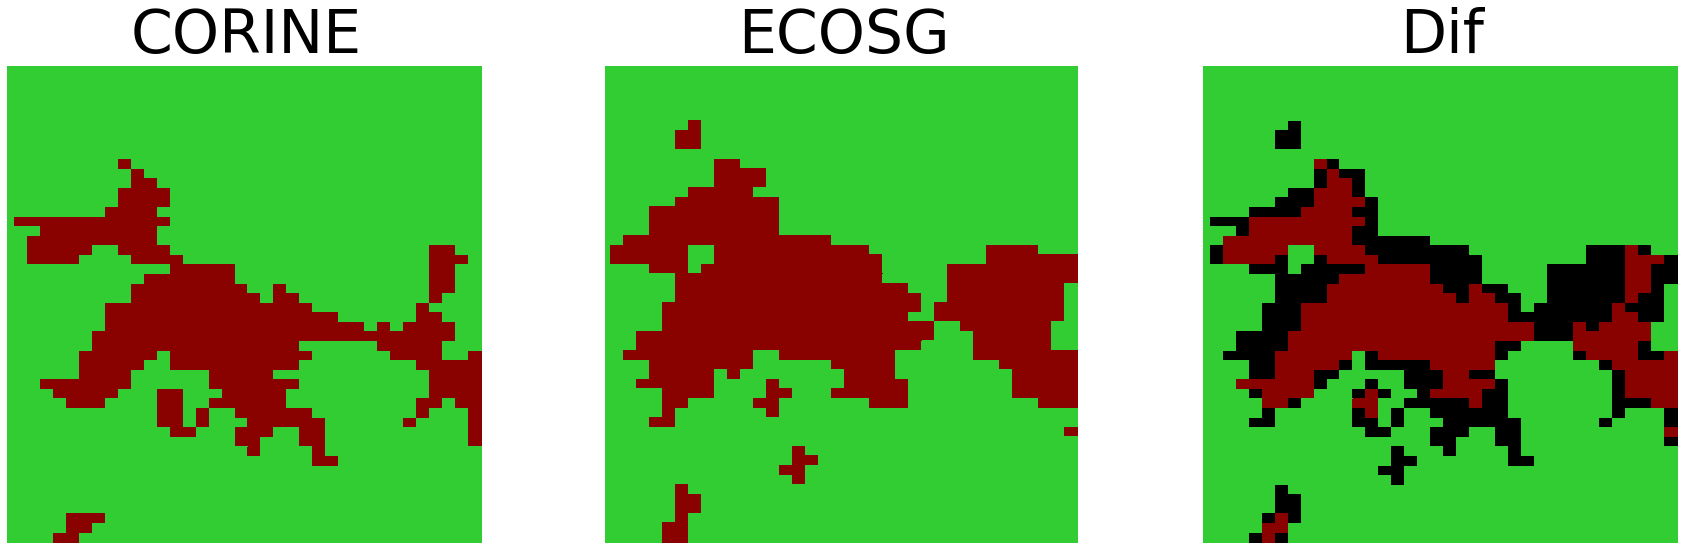

In [ ]:
Dif = findDif(DFCOR,DFECO)

fig=plt.figure(figsize=(30,60))
grid = plt.GridSpec(2,3, hspace=0.1, wspace=0.25)

ax0=fig.add_subplot(grid[0, 0],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax0.pcolormesh(LONC,LATC,DFCOR,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)
ax0.axis('off')

ax1=fig.add_subplot(grid[0, 1],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONECO, LATECO)
c=ax1.pcolormesh(LONECO,LATECO,DFECO,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.axis('off')

ax2=fig.add_subplot(grid[0, 2],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax2.pcolormesh(LONC,LATC,Dif,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.axis('off')

ax0.set_title('CORINE', fontsize= 60)
ax1.set_title('ECOSG', fontsize= 60)
ax2.set_title('Dif', fontsize= 60)

#cbar_ax = fig.add_subplot(grid[:, 1])
#cb=plt.colorbar(c, ax=cbar_ax, ticks=np.arange(0.5,len(PrimeCover)),
#                extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(PrimeCover)
#cb.ax.tick_params(labelsize=15)
#cbar_ax.tick_params(labelsize=15)
#cbar_ax.axis('off')
fig.savefig('DifPlot.png',format='png',quality=95,bbox_inches='tight')

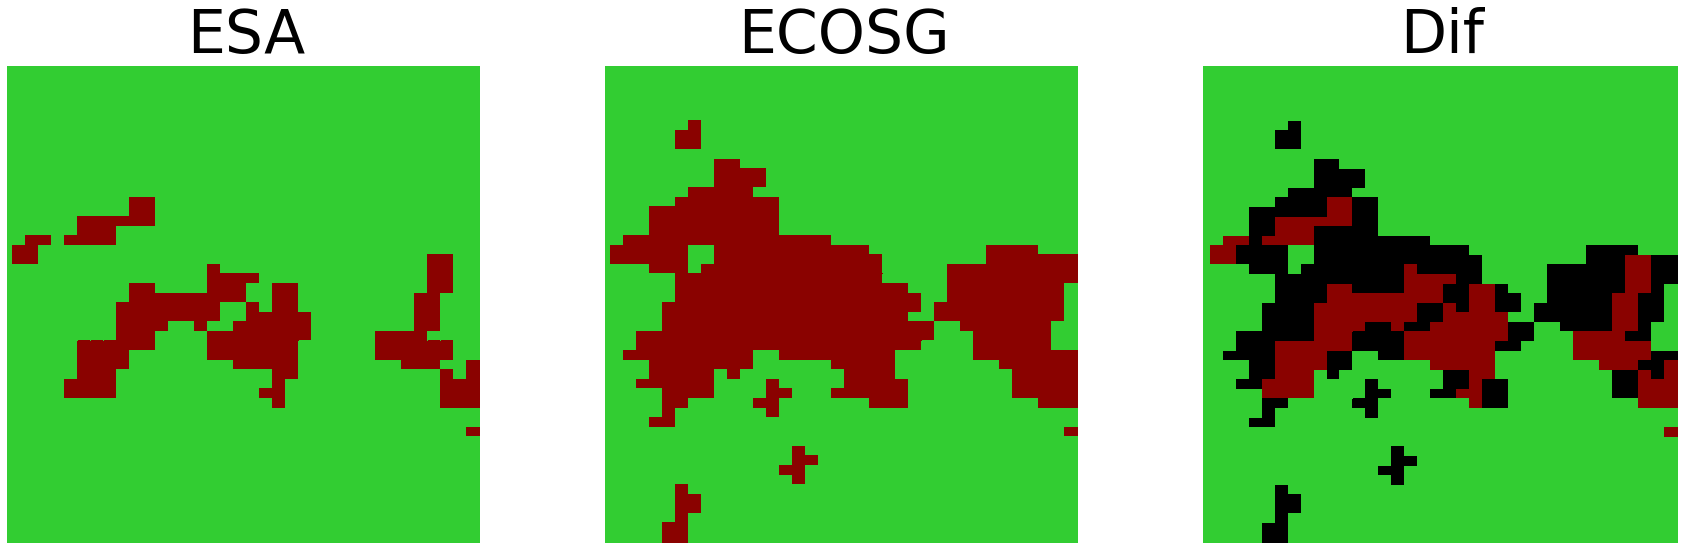

In [ ]:
Dif = findDif(DFESA,DFECO)

fig=plt.figure(figsize=(30,60))
grid = plt.GridSpec(2,3, hspace=0.1, wspace=0.25)

ax0=fig.add_subplot(grid[0, 0],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONESA, LATESA)
c=ax0.pcolormesh(LONESA,LATESA,DFESA,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)
ax0.axis('off')

ax1=fig.add_subplot(grid[0, 1],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONECO, LATECO)
c=ax1.pcolormesh(LONECO,LATECO,DFECO,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.axis('off')

ax2=fig.add_subplot(grid[0, 2],adjustable='box',
                    aspect=(xmin-xmax)/((ymin-ymax)))
LONg, LATg = np.meshgrid(LONC, LATC)
c=ax2.pcolormesh(LONC,LATC,Dif,cmap=colCOR,vmin=0,vmax=len(PrimeCover))

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.axis('off')

ax0.set_title('ESA', fontsize= 60)
ax1.set_title('ECOSG', fontsize= 60)
ax2.set_title('Dif', fontsize= 60)

#cbar_ax = fig.add_subplot(grid[:, 1])
#cb=plt.colorbar(c, ax=cbar_ax, ticks=np.arange(0.5,len(PrimeCover)),
#                extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(PrimeCover)
#cb.ax.tick_params(labelsize=15)
#cbar_ax.tick_params(labelsize=15)
#cbar_ax.axis('off')
fig.savefig('DifPlot.png',format='png',quality=95,bbox_inches='tight')